# 네이버 영화리뷰 감성분석

In [11]:
#%pip install konlpy torchinfo -q

In [12]:
!curl -L -o ratings_train.txt https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!curl -L -o ratings_test.txt  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 38 13.9M   38 5475k    0     0  12.6M      0  0:00:01 --:--:--  0:00:01 12.6M
100 13.9M  100 13.9M    0     0  20.4M      0 --:--:-- --:--:-- --:--:-- 20.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4778k  100 4778k    0     0  20.5M      0 --:--:-- --:--:-- --:--:-- 20.7M


In [13]:
# 데이터로드
import pandas as pd

ratings_train_df = pd.read_csv('ratings_train.txt', sep='\t')
ratings_test_df = pd.read_csv('ratings_test.txt', sep='\t')
len(ratings_train_df), len(ratings_test_df)

(150000, 50000)

In [14]:
ratings_train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [15]:
ratings_test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [16]:
# 결측치제거
ratings_train_df = ratings_train_df.dropna(how='any')
ratings_test_df = ratings_test_df.dropna(how='any')

print(ratings_train_df.isnull().sum())
print(ratings_test_df.isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


In [17]:
# 학습시간을 고려해서 데이터 샘플링
ratings_train_df = ratings_train_df.sample(n=50000, random_state=42)
ratings_test_df = ratings_test_df.sample(n=5000, random_state=42)
ratings_train_df.shape, ratings_test_df.shape

((50000, 3), (5000, 3))

## 데이터전처리

In [18]:
import re
from konlpy.tag import Okt

def preprocessing(sentence, okt=Okt(jvmpath=r"C:\Program Files\Java\jdk-21\bin\server\jvm.dll")):
    # 개행문자 제거
    sentence = re.sub(r'\n', ' ', sentence)
    # 한글외 문자 제거
    sentence = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', '', sentence)
    # 형태소분석(어간추출)
    tokens = okt.morphs(sentence, stem=True)
    # 불용어제거
    stopwords = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

In [19]:
sample = """진짜 이상한 영화를 봤어요.
It's weird~~~~~~~~~~~~~~ ㅋㅋㅋㅋㅋ
8000원이 아까웠어요🤐🤐🤐
"""
preprocessing(sample)

['진짜', '이상하다', '영화', '보다', 'ㅋㅋㅋㅋㅋ', '원', '아깝다']

In [ ]:
# 텍스트 전처리 후 학습/테스트 리스트 생성
from tqdm import tqdm

X_train = []
y_train = []
X_test = []
y_test = []

for index, row in tqdm(ratings_train_df.iterrows()):    # 학습 데이터 행 단위 순회
    doc, label = row['document'], row['label']
    X_train.append(preprocessing(doc))
    y_train.append(label)

for index, row in tqdm(ratings_test_df.iterrows()):     # 테스트 데이터 행 단위 순회
    doc, label = row['document'], row['label']
    X_test.append(preprocessing(doc))
    y_test.append(label)


50000it [01:05, 764.58it/s]
5000it [00:06, 714.93it/s]


In [21]:
X_train[:3]
y_train[:3]
X_test[:3]
y_test[:3]

[1, 1, 0]

In [36]:
# 정수인코딩/패딩 처리
from tensorflow.keras.preprocessing.text import Tokenizer           # 텍스트 -> 정수 시퀀스 변환 도구
from tensorflow.keras.preprocessing.sequence import pad_sequences   # 패딩(길이 통일) 도구

vocab_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)             # 학습 테스트로 단어 사전(word_index) 학습
X_train_encoded = tokenizer.texts_to_sequences(X_train) # 학습 테스트를 정수 시퀀스로 변환
X_test_encoded = tokenizer.texts_to_sequences(X_test)   # 테스트 텍스를 정수 시퀀스로 변횐

print(X_train_encoded[:3])
print(X_test_encoded[:3])

[[8917, 28], [521, 327, 22, 871, 7, 2], [716, 84, 454, 12, 2, 62, 78, 138, 33, 234]]
[[1152, 268, 22, 4, 156, 28, 1576], [255, 251, 6], [1644, 5, 293]]


평균: 10.75, 중위값: 8.0


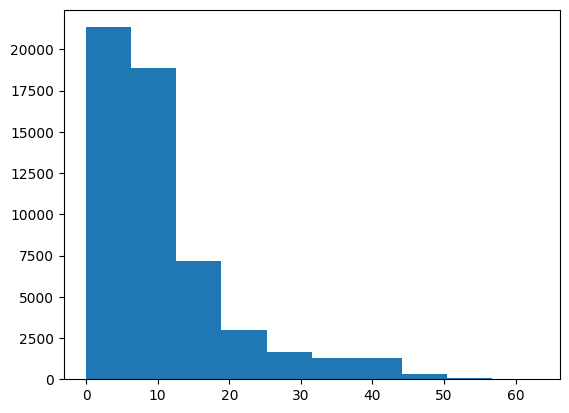

In [23]:
# 리뷰길이 평균/중위값 확인
import matplotlib.pyplot as plt
import numpy as np

X_train_len = [len(seq) for seq in X_train_encoded]
X_test_len = [len(seq) for seq in X_test_encoded]

mean = np.mean(X_train_len + X_test_len)
median = np.median(X_train_len + X_test_len)
print(f'평균: {mean:.2f}, 중위값: {median}')

plt.hist(X_train_len + X_test_len)
plt.show()

In [ ]:
max_len = 15

X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len) # 학습 데이터를 max_len 길이로 패딩/자르기
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_len)   # 테스트 데이터를 max_len 길이로 패딩/자르기

## 텍스트 디코딩

In [ ]:
# 단어사전
# - tokenizer.index_word
# - tokenizer.word_index

def decode_sentence(encoded_sentence):
    decoded = [tokenizer.index_word.get(n, '_') for n in encoded_sentence]
    return ' '.join(decoded)

print(X_train_padded[0])
print(decode_sentence(X_train_padded[0]))

print(ratings_test_df.iloc[0, 1])           # 첫 원본 텍스트 리뷰(document 컬럼) 확인
print(X_test_padded[0])
print(decode_sentence(X_test_padded[0]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0 8917
   28]
_ _ _ _ _ _ _ _ _ _ _ _ _ 원본 최고
찐한 여운과 함께...내 인생 최고의 미드
[   0    0    0    0    0    0    0    0 1152  268   22    4  156   28
 1576]
_ _ _ _ _ _ _ _ 찌다 여운 과 하다 인생 최고 미드


In [26]:
print(preprocessing('찐한 여운과 함께...내 인생 최고의 미드'))

['찌다', '여운', '과', '하다', '인생', '최고', '미드']


## 모델 설계

In [ ]:
import torch
import torch.nn as nn

# 임베딩 + 양방향 LSTM -> 정/역방향 은닉 결합 -> FC로 이진 감성 로짓을 출력하는 분류기 모델
class NSMC(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size,     # 임베딩 테이블 행 개수(단어 사전 크기)
            embedding_dim,  # 임베딩 벡터 차원    
            padding_idx=0   # PAD 토큰 인덱스(0)은 업데이트 안함(학습에서 제외)
              ) # 정수 토큰 ID -> 임베딩 벡터로 변환
        
        self.lstm = nn.LSTM(
            embedding_dim,       # input_size : 각 타임스텝별 입력 차원(=임베딩 차원)
            hidden_dim,          # hidden_size = 은닉 상태 차원
            batch_first=True,    # 입력/출력 텐서 형태를 (B, T, *)로 사용
            bidirectional=True   # 정방향+역방향을 함께 학습 (출력/hidden이 2배)
                )
        self.fc = nn.Linear(hidden_dim * 2, 1)  # 정/역방향 은닉 결합(2H) -> logit 1개

    def forward(self, x):
        x = self.embedding(x)           # (B, T) -> (B, T, E)
        _, (hidden, _) = self.lstm(x)   # hidden: (L*2, B, H)
        f_h = hidden[-2]                # (batch_size, hidden_size) : 정방향 마지막 레이어 은닉
        b_h = hidden[-1]                # (batch_size, hidden_size) : 역방향 마지막 레이어 은닉
        hidden = torch.cat((f_h, b_h), dim=1)   # (B, H) + (B, H) = (B, 2H)
        output = self.fc(hidden)                # (B, 2H) -> (B, 1)
        return output

embedding_dim = 100     # 임베딩 차원
hidden_dim = 128        # 은닉 차원
model = NSMC(vocab_size, embedding_dim, hidden_dim)
model

NSMC(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [28]:
%pip install torchinfo -q
from torchinfo import summary
summary(model)

Note: you may need to restart the kernel to use updated packages.


Layer (type:depth-idx)                   Param #
NSMC                                     --
├─Embedding: 1-1                         2,000,000
├─LSTM: 1-2                              235,520
├─Linear: 1-3                            257
Total params: 2,235,777
Trainable params: 2,235,777
Non-trainable params: 0

## 모델 학습

In [ ]:
# tensor, dataset, dataloader준비
batch_size = 64
train_size = int(len(X_train_padded) * 0.8) # 40000
val_size = len(X_train_padded) - train_size # 10000

X_train_padded = torch.tensor(X_train_padded, dtype=torch.long)
X_test_padded = torch.tensor(X_test_padded, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float).unsqueeze(1)  # 라벨 텐서화 진행 후 (N, ) -> (N, 1)로 맞춰준다.
y_test = torch.tensor(y_test, dtype=torch.float).unsqueeze(1)    # 라벨 텐서화 진행 후 (N, ) -> (N, 1)로 맞춰준다.

print(X_train_padded.shape, X_test_padded.shape)
print(y_train.shape, y_test.shape)

torch.Size([50000, 15]) torch.Size([5000, 15])
torch.Size([50000, 1]) torch.Size([5000, 1])


In [30]:
from torch.utils.data import TensorDataset, DataLoader, random_split

train_dataset = TensorDataset(X_train_padded, y_train)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = TensorDataset(X_test_padded, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))
print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

40000 10000 5000
625 157 79


In [37]:
# 학습/검증
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NSMC(vocab_size, embedding_dim, hidden_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,      # 적용할 옵티마이저
    mode='min',     # val_loss를 최소화하는 방향으로 모니터링
    factor=0.5,     # 학습률 감소 비율(현재 lr * 0.5)
    patience=3      # 개선이 없을 때 기다릴 에폭 수
)   # 검증 손실 정체 시 학습률 감소

# 시각화 지표
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련
early_stopping_patience = 1
best_val_loss = float('inf')
early_stopping_counter = 0

epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x_batch, y_batch in train_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().item()
        p = torch.sigmoid(output)
        pred = (p >= 0.5).float()
        correct += (pred == y_batch).sum().float().detach().cpu().item()
        total += len(y_batch)

    # 학습 기록
    train_loss = total_loss / len(train_dataloader) # 스텝당 평균손실
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 검증
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x_batch, y_batch in val_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)

            val_loss += loss.detach().cpu().item()
            p = torch.sigmoid(output)
            pred = (p >= 0.5).float()
            val_correct += (pred == y_batch).sum().float().detach().cpu().item()
            val_total += len(y_batch)

    val_loss = val_loss / len(val_dataloader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 스케쥴러 검사
    scheduler.step(val_loss)
    lr = scheduler.get_last_lr()[0]
    print(
        f'Epoch({epoch + 1}/{epochs}): '
        f'Train Loss {train_loss:.4f}, '
        f'Train Acc {train_acc:.4f}, '
        f'Val Loss {val_loss:.4f}, '
        f'Val Acc {val_acc:.4f}, '
        f'LR {lr}'
    )

    # 조기종료
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f'Early stopped at Epoch {epoch + 1}...')
            break

Epoch(1/100): Train Loss 0.6429, Train Acc 0.6379, Val Loss 0.5792, Val Acc 0.6976, LR 0.0001
Epoch(2/100): Train Loss 0.5417, Train Acc 0.7245, Val Loss 0.5242, Val Acc 0.7390, LR 0.0001
Epoch(3/100): Train Loss 0.4629, Train Acc 0.7754, Val Loss 0.4589, Val Acc 0.7798, LR 0.0001
Epoch(4/100): Train Loss 0.4145, Train Acc 0.8065, Val Loss 0.4433, Val Acc 0.7915, LR 0.0001
Epoch(5/100): Train Loss 0.3851, Train Acc 0.8248, Val Loss 0.4349, Val Acc 0.7963, LR 0.0001
Epoch(6/100): Train Loss 0.3620, Train Acc 0.8385, Val Loss 0.4300, Val Acc 0.8021, LR 0.0001
Epoch(7/100): Train Loss 0.3400, Train Acc 0.8519, Val Loss 0.4303, Val Acc 0.8013, LR 0.0001
Early stopped at Epoch 7...


In [32]:
train_losses, val_losses, train_accs, val_accs

([0.6409795382022858,
  0.5069330355644226,
  0.43974315404891967,
  0.406053205370903,
  0.3809478209257126,
  0.35884704320430755],
 [0.5619822153999547,
  0.4770721512235654,
  0.45195819921554276,
  0.4470954489935735,
  0.42896296795766065,
  0.4337000886725772],
 [0.630975, 0.74565, 0.79165, 0.81475, 0.829375, 0.84325],
 [0.7018, 0.7692, 0.783, 0.7882, 0.7985, 0.799])

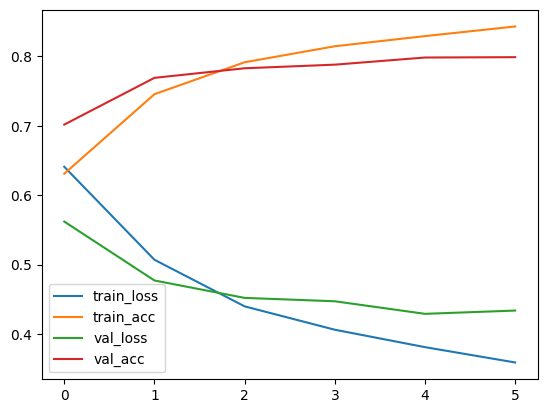

In [33]:
# 시각화
import matplotlib.pyplot as plt

history_df = pd.DataFrame({
    'train_loss': train_losses,
    'train_acc': train_accs,
    'val_loss': val_losses,
    'val_acc': val_accs
})
history_df.plot()
plt.show()

## 모델 평가

In [34]:
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        output = model(x_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.detach().cpu().item()

        p = torch.sigmoid(output)
        pred = (p >= 0.5).float()
        test_correct += (pred == y_batch).sum().detach().cpu().item()
        test_total += len(y_batch)

test_loss = test_loss / len(test_dataloader)
test_acc = test_correct / test_total

print(f'Testset: Loss {test_loss:.4f}, Acc {test_acc:.4f}')

Testset: Loss 0.4446, Acc 0.7950


## 모델 추론

In [ ]:
# 여러 문장을 입력받아 전처리 -> 인코딩 -> 패딩 -> 모델 추론으로 감성 라벨(긍정/부정)을 반환
def movie_review_sentimental_analysis(sentences):

    # 토큰화/전처리
    tokens = [preprocessing(sent) for sent in sentences]
    # 정수인코딩/패딩처리
    encoded_sequences = tokenizer.texts_to_sequences(tokens)
    padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len)
    # 텐서변환
    X = torch.tensor(padded_sequences, dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        output = model(X)
        p = torch.sigmoid(output)
        pred = (p >= 0.5).float()

        return ['긍정' if pr == 1 else '부정' for pr in pred]

samples = [
    '이 영화는 정말 짜증나네요.',
    "오랜만에 수작을 만났습니다.",
    "내가 만들어도 이거보다는 ...",
    "고구마 영화",
    "황정민이 최고야!",
    "너무 유치해서 오글거려요~"
]
movie_review_sentimental_analysis(samples)

['부정', '긍정', '부정', '긍정', '긍정', '부정']